## importing required libraries

In [171]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## downloading ticker data and performing feature engineering

In [172]:
ticker_data = yf.Ticker('^GSPC').history(period = 'max')
ticker_data = ticker_data.drop(columns=['Dividends', 'Stock Splits'])
# ticker_data = ticker_data[ticker_data.index >= '2000-01-01']

In [173]:
ticker_data['close_body'] = abs(ticker_data['Close'] - ticker_data['Open'])

ticker_data['upper_wick'] = ticker_data['High'] - np.maximum(ticker_data['Open'].values, ticker_data['Close'].values)

ticker_data['lower_wick'] =  np.minimum(ticker_data['Open'].values, ticker_data['Close'].values) - ticker_data['Low']

lookback_window = 14

ticker_data['close_body'] = abs(ticker_data['Close'] - ticker_data['Open'])

ticker_data['volume_imbalance_signal'] = (ticker_data['Close'] - ticker_data['Open'])*ticker_data['Volume']
ticker_data['volatility_of_pressure'] = ticker_data['volume_imbalance_signal'].rolling(window = lookback_window).std()

ticker_data['intraday_pressure_index'] = (ticker_data['High'] - ticker_data['Low'])/ticker_data['Volume']

lookback_window = 14
vis_mean = ticker_data['volume_imbalance_signal'].rolling(window=lookback_window).mean()
vis_std = ticker_data['volume_imbalance_signal'].rolling(window=lookback_window).std(ddof=0) # to make sure that the population mean is calcualted
ticker_data['volume_imbalance_signal_z_score'] = (ticker_data['volume_imbalance_signal']-vis_mean)/(vis_std)

ticker_data['cumulative_abnormal_pressure'] = ticker_data['volume_imbalance_signal_z_score'].rolling(window = lookback_window).sum()

ticker_data['range_volume_volatility'] = ((ticker_data['High'] - ticker_data['Low'])/ticker_data['Close'])/ticker_data['Volume'].rolling(window = lookback_window).mean()

ticker_data['order_flow_proxy'] = (ticker_data['Close'] - (ticker_data['High'] - ticker_data['Low'])/2)*ticker_data['Volume']

ticker_data['volume_shock_index'] = (ticker_data['Volume'] - ticker_data['Volume'].rolling(window = lookback_window).mean())/ticker_data['Volume'].rolling(window = lookback_window).std()

ticker_data['price_momentum_pressure'] = ((ticker_data['Close'] - ticker_data['Close'].rolling(window = lookback_window).mean())/ticker_data['Close'].rolling(window = lookback_window).mean())*ticker_data['Volume']

# ticker_data['Close'] = ticker_data['Close'].pct_change().dropna()
# ticker_data['close_direction'] = np.where(ticker_data['Close'] > 0, 1, 0)

returns = ticker_data['Close'].pct_change()

# defining the target variable 'close_direction' based on the returns
ticker_data['close_direction'] = np.where(returns > 0, 1, 0)

# replacing the close' column with returns to make sure it's not a direct price series
ticker_data['Close'] = returns

ticker_data = ticker_data.dropna()

In [174]:
ticker_data.info() # --> all data present are of numeric type

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15993 entries, 1962-01-19 00:00:00-05:00 to 2025-08-28 00:00:00-04:00
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Open                             15993 non-null  float64
 1   High                             15993 non-null  float64
 2   Low                              15993 non-null  float64
 3   Close                            15993 non-null  float64
 4   Volume                           15993 non-null  int64  
 5   close_body                       15993 non-null  float64
 6   upper_wick                       15993 non-null  float64
 7   lower_wick                       15993 non-null  float64
 8   volume_imbalance_signal          15993 non-null  float64
 9   volatility_of_pressure           15993 non-null  float64
 10  intraday_pressure_index          15993 non-null  float64
 11  volume_imbalance_signal_z_score  

In [175]:
ticker_data.describe() # --> large range gap present b/w the variables, will need to perform scaling for faster convergence while training the model!

,Open,High,Low,Close,Volume,close_body,upper_wick,lower_wick,volume_imbalance_signal,volatility_of_pressure,intraday_pressure_index,volume_imbalance_signal_z_score,cumulative_abnormal_pressure,range_volume_volatility,order_flow_proxy,volume_shock_index,price_momentum_pressure,close_direction
count,15993.000000,15993.000000,15993.000000,15993.000000,1.599300e+04,15993.000000,15993.000000,15993.000000,1.599300e+04,1.599300e+04,1.599300e+04,15993.000000,15993.000000,1.599300e+04,1.599300e+04,15993.000000,1.599300e+04,15993.000000
mean,1051.510249,1057.691551,1044.953585,0.000338,1.451689e+09,7.039144,2.544067,3.154756,2.615448e+08,3.210628e+10,inf,-0.020271,-0.283602,4.961221e-10,3.360572e+12,0.018985,1.225098e+06,0.529294
std,1308.562144,1315.491993,1301.144064,0.010396,1.867475e+09,13.709756,5.387060,6.700070,8.267183e+10,7.751852e+10,NaN,1.012637,3.241722,9.304136e-10,6.013648e+12,1.049879,7.159849e+07,0.499157
min,52.320000,52.830002,51.349998,-0.204669,0.000000e+00,0.000000,0.000000,0.000000,-1.930595e+12,2.224746e+05,0.000000e+00,-3.553842,-12.281394,0.000000e+00,0.000000e+00,-3.397959,-2.024372e+09,0.000000
25%,105.050003,105.949997,104.120003,-0.004300,2.509000e+07,0.489998,0.279999,0.319946,-2.894853e+08,1.894471e+07,7.349117e-09,-0.658921,-2.445169,3.882663e-12,2.481783e+09,-0.720061,-6.872585e+05,0.000000
50%,453.519989,454.920013,452.059998,0.000463,2.715600e+08,1.709961,0.680000,0.730003,1.056295e+06,8.321951e+08,1.677496e-08,-0.024601,-0.275734,3.026427e-11,1.222650e+11,-0.069898,1.447987e+05,1.000000
75%,1362.010010,1369.229980,1350.109985,0.005246,3.160310e+09,7.729980,2.419922,3.109985,9.402535e+08,3.178753e+10,6.396315e-08,0.626877,1.865756,6.172023e-10,4.916140e+12,0.688963,6.981516e+06,1.000000
max,6483.839844,6495.439941,6466.959961,0.115800,1.145623e+10,491.620117,184.319824,152.779785,4.665278e+12,1.531974e+12,inf,3.437585,12.392651,1.638953e-08,5.277337e+13,3.425986,8.583653e+08,1.000000


In [176]:
ticker_data.corr() # --> clear that features are highly correlated, performing PCA and exploring the results

,Open,High,Low,Close,Volume,close_body,upper_wick,lower_wick,volume_imbalance_signal,volatility_of_pressure,intraday_pressure_index,volume_imbalance_signal_z_score,cumulative_abnormal_pressure,range_volume_volatility,order_flow_proxy,volume_shock_index,price_momentum_pressure,close_direction
Open,1.000000,0.999970,0.999961,0.005096,0.759461,0.574815,0.530311,0.540537,0.004063,0.635233,-0.430595,-0.015648,-0.045981,-0.387670,0.946107,0.005140,0.051351,0.015139
High,0.999970,1.000000,0.999945,0.008791,0.760321,0.578121,0.532889,0.540788,0.009261,0.637567,-0.430550,-0.012496,-0.045553,-0.387774,0.946652,0.005704,0.051134,0.017376
Low,0.999961,0.999945,1.000000,0.009590,0.758256,0.571001,0.529351,0.536594,0.009456,0.632840,-0.430740,-0.012215,-0.044408,-0.387558,0.945402,0.003894,0.055781,0.018146
Close,0.005096,0.008791,0.009590,1.000000,-0.006914,-0.030167,-0.027318,-0.052633,0.531172,0.006994,-0.033103,0.788618,0.254775,-0.010753,0.003144,0.047380,0.311989,0.669171
Volume,0.759461,0.760321,0.758256,-0.006914,1.000000,0.561234,0.476765,0.497399,-0.008269,0.648508,-0.475556,-0.016564,-0.065015,-0.406253,0.806807,0.112380,-0.068724,0.007645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
range_volume_volatility,-0.387670,-0.387774,-0.387558,-0.010753,-0.406253,-0.247021,-0.197721,-0.207791,-0.001826,-0.218735,0.941693,0.010573,-0.018028,1.000000,-0.295661,0.063173,-0.009908,-0.015514
order_flow_proxy,0.946107,0.946652,0.945402,0.003144,0.806807,0.612110,0.554581,0.571635,0.009386,0.709159,-0.335930,-0.013117,-0.050487,-0.295661,1.000000,0.084392,0.001399,0.009192
volume_shock_index,0.005140,0.005704,0.003894,0.047380,0.112380,0.111670,0.068248,0.080369,-0.046019,-0.010719,-0.039728,0.075989,0.074142,0.063173,0.084392,1.000000,-0.099993,0.064888
price_momentum_pressure,0.051351,0.051134,0.055781,0.311989,-0.068724,-0.226844,-0.163407,-0.197506,0.329803,-0.148334,-0.023298,0.119885,0.260308,-0.009908,0.001399,-0.099993,1.000000,0.160696


## performing PCA

In [177]:
from sklearn.decomposition import PCA

ticker_data = ticker_data.replace([np.inf, -np.inf], np.nan).dropna()
pca = PCA(n_components=1)
pca.fit_transform(ticker_data.drop(columns = ['close_direction']))

array([[-3.36067749e+12],
       [-3.36067464e+12],
       [-3.36070789e+12],
       ...,
       [ 2.80181340e+13],
       [ 2.34357075e+13],
       [ 3.56834347e+12]])

In [178]:
ticker_pca = pd.DataFrame(data = pca.components_.T, index = ticker_data.drop(columns = ['close_direction']).columns, columns = ['explain_power'])
ticker_pca = ticker_pca.sort_values(by = 'explain_power', ascending=False) # --> variables best explaining the uncorrelated principle component. Taking top 2 from top and bottom!
ticker_pca

,explain_power
order_flow_proxy,9.999582e-01
volatility_of_pressure,9.142283e-03
Volume,2.505341e-04
volume_imbalance_signal,1.291242e-04
price_momentum_pressure,1.644753e-08
...,...
Close,5.393821e-18
range_volume_volatility,-4.574583e-23
intraday_pressure_index,-3.760754e-21
volume_imbalance_signal_z_score,-2.209089e-15


## EDA and model building with top-2 head and tail variables

In [179]:
columns_to_keep = ticker_pca.head(2).index.tolist()
columns_to_keep.extend(ticker_pca.tail(2).index.tolist())
columns_to_keep # --> instead of using all the features, using these 4 to train and build forecasting model

['order_flow_proxy',
 'volatility_of_pressure',
 'volume_imbalance_signal_z_score',
 'cumulative_abnormal_pressure']

In [180]:
eda_copy = ticker_data[columns_to_keep]

for column in columns_to_keep:
    eda_copy[column] = eda_copy[column]/eda_copy[column].max()

C:\Users\Munj Patel\AppData\Local\Temp\ipykernel_9304\2091019536.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_copy[column] = eda_copy[column]/eda_copy[column].max()


In [181]:
type(eda_copy)

pandas.core.frame.DataFrame

In [182]:
ticker_data.shape

(15992, 18)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

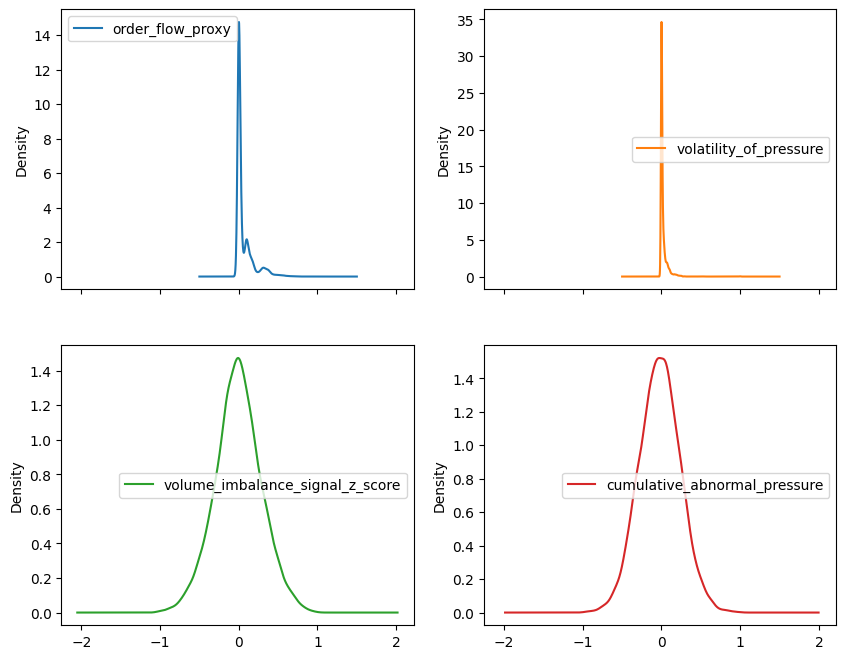

In [183]:
eda_copy.plot(kind = 'kde', subplots = True, layout = (2,2), figsize = (10,8)) # --> shows high peaks, which makes sense given that we are dealing with financial data

order_flow_proxy                      Axes(0.125,0.53;0.352273x0.35)
volatility_of_pressure             Axes(0.547727,0.53;0.352273x0.35)
volume_imbalance_signal_z_score       Axes(0.125,0.11;0.352273x0.35)
cumulative_abnormal_pressure       Axes(0.547727,0.11;0.352273x0.35)
dtype: object

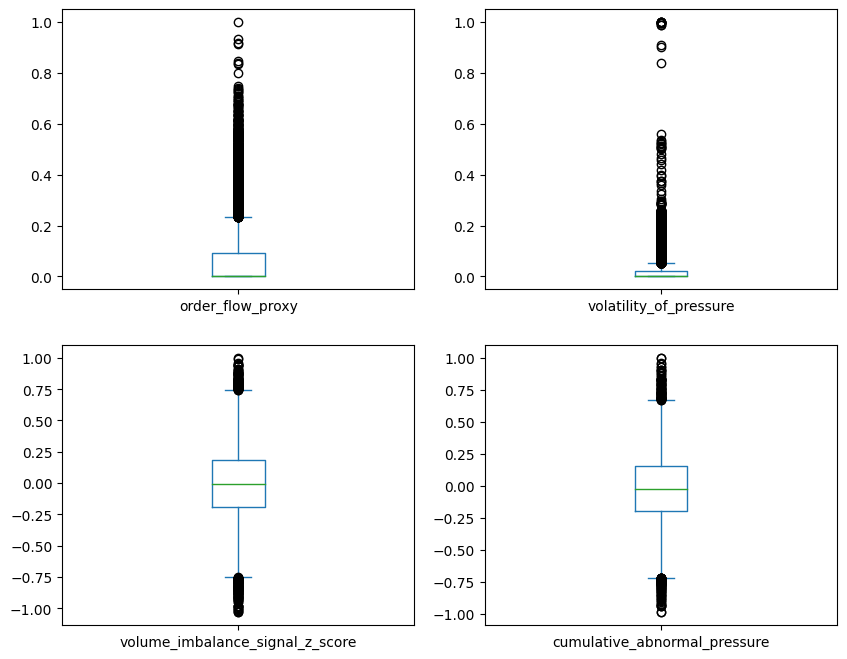

In [184]:
eda_copy.plot(kind = 'box', subplots = True, layout = (2,2), figsize = (10,8)) # --> large number of outliers detected, indicating high volatility periods presence in the data

array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>]], dtype=object)

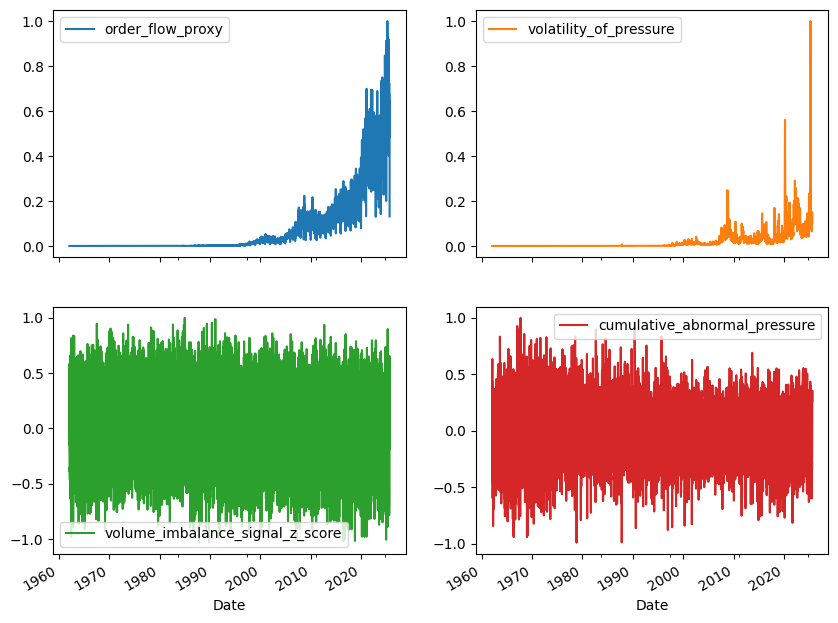

In [185]:
eda_copy.plot(kind = 'line', subplots = True, layout = (2,2), figsize = (10,8)) # --> large variations are observable from the figures.

In [186]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from tqdm import tqdm

In [187]:
x = ticker_data[columns_to_keep]
y = ticker_data['close_direction']

valid_index = x.dropna().index.intersection(y.dropna().index)
x = x.loc[valid_index]
y = y.loc[valid_index]

In [188]:
rf_classifier_baseline = RandomForestClassifier(n_estimators=100, random_state=0)
nb_classifier_baseline = BernoulliNB()
mlp_classifier_baseline = MLPClassifier(max_iterations = 500)

In [189]:
def get_model_name(model_instance):
    return model_instance.__class__.__name__

In [190]:
models_list = [rf_classifier_baseline, nb_classifier_baseline, mlp_classifier_baseline]

In [191]:
baseline_scores = {f"{models_list[index].__class__.__name__}":[] for index in range(len(models_list))}

In [192]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from collections import defaultdict
from tqdm import tqdm
import numpy as np

# Convert to numpy early for speed
x_np = x.to_numpy()
y_np = y.to_numpy()

tscv = TimeSeriesSplit(n_splits=10)
baseline_scores = defaultdict(list)

for fold_idx, (train_index, test_index) in enumerate(tscv.split(x_np)):
    x_train, x_test = x_np[train_index], x_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Drop any rows with NaNs after split (rare if cleaned earlier)
    mask_train = ~np.isnan(x_train).any(axis=1)
    mask_test = ~np.isnan(x_test).any(axis=1)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_test, y_test = x_test[mask_test], y_test[mask_test]

    if len(x_test) == 0 or len(x_train) == 0:
        print(f"Skipping fold {fold_idx+1} due to empty dataset after cleaning.")
        continue

    # Scale
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    for model in tqdm(models_list, desc=f"Fold {fold_idx+1}"):
        model_name = model.__class__.__name__

        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)
        score = accuracy_score(y_test, y_pred)

        baseline_scores[model_name].append(score)

    print(f"✅ Completed Fold {fold_idx+1}")

Fold 1:  33%|█████████████████████████▎                                                  | 1/3 [00:00<00:01,  1.45it/s]C:\Users\Munj Patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Fold 1: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


✅ Completed Fold 1


Fold 2:  33%|█████████████████████████▎                                                  | 1/3 [00:01<00:02,  1.24s/it]C:\Users\Munj Patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Fold 2: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


✅ Completed Fold 2


Fold 3:  33%|█████████████████████████▎                                                  | 1/3 [00:01<00:03,  1.78s/it]C:\Users\Munj Patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Fold 3: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.23s/it]


✅ Completed Fold 3


Fold 4: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.70s/it]


✅ Completed Fold 4


Fold 5: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.23s/it]


✅ Completed Fold 5


Fold 6: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.50s/it]


✅ Completed Fold 6


Fold 7: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]


✅ Completed Fold 7


Fold 8: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.01s/it]


✅ Completed Fold 8


Fold 9: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.72s/it]


✅ Completed Fold 9


Fold 10: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.88s/it]

✅ Completed Fold 10


In [193]:
baseline_scores

defaultdict(list,
            {'RandomForestClassifier': [0.887130075705437,
              0.9036476256022024,
              0.8699242945629732,
              0.8513420509291122,
              0.8960770818995183,
              0.9029593943565037,
              0.8850653819683414,
              0.905712319339298,
              0.8396421197522368,
              0.8183069511355816],
             'BernoulliNB': [0.860977288368892,
              0.9112181693048864,
              0.8830006882312457,
              0.8830006882312457,
              0.874741913282863,
              0.9008947006194081,
              0.9015829318651066,
              0.8878183069511356,
              0.8368891947694426,
              0.8265657260839642],
             'MLPClassifier': [0.8864418444597385,
              0.8981417756366139,
              0.7267721954576738,
              0.7845836200963524,
              0.8492773571920165,
              0.8382656572608397,
              0.8706125258086718,
        

In [194]:
# --- After the loop, print the final results ---

for model_name in baseline_scores.keys():
    print("\n" + "="*50)
    print("FINAL RESULTS:")
    print()
    print(f"Baseline Model: {model_name}, Average Accuracy: {np.mean(baseline_scores[model_name]):.4f} (+/- {np.std(baseline_scores[model_name]):.4f})")


FINAL RESULTS:

Baseline Model: RandomForestClassifier, Average Accuracy: 0.8760 (+/- 0.0288)

FINAL RESULTS:

Baseline Model: BernoulliNB, Average Accuracy: 0.8767 (+/- 0.0264)

FINAL RESULTS:

Baseline Model: MLPClassifier, Average Accuracy: 0.8361 (+/- 0.0578)


In [195]:
importance = rf_classifier_baseline.feature_importances_
importance_data = pd.DataFrame({'feature':x.columns, 'importance':importance})
importance_data = importance_data.sort_values(by = 'importance', ascending=False)
importance_data

,feature,importance
2,volume_imbalance_signal_z_score,0.741316
3,cumulative_abnormal_pressure,0.114656
1,volatility_of_pressure,0.072687
0,order_flow_proxy,0.071341


## model building with top-3 head and tail variables

In [196]:
columns_to_keep_2 = ticker_pca.head(3).index.tolist()
columns_to_keep_2.extend(ticker_pca.tail(3).index.tolist())
columns_to_keep_2 # --> instead of using all the features, using these 4 to train and build forecasting model

['order_flow_proxy',
 'volatility_of_pressure',
 'Volume',
 'intraday_pressure_index',
 'volume_imbalance_signal_z_score',
 'cumulative_abnormal_pressure']

In [197]:
x = ticker_data[columns_to_keep]
y = ticker_data['close_direction']

valid_index = x.dropna().index.intersection(y.dropna().index)
x = x.loc[valid_index]
y = y.loc[valid_index]

In [198]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from collections import defaultdict
from tqdm import tqdm
import numpy as np

# Convert to numpy early for speed
x_np = x.to_numpy()
y_np = y.to_numpy()

tscv = TimeSeriesSplit(n_splits=10)
baseline_scores = defaultdict(list)

for fold_idx, (train_index, test_index) in enumerate(tscv.split(x_np)):
    x_train, x_test = x_np[train_index], x_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Drop any rows with NaNs after split (rare if cleaned earlier)
    mask_train = ~np.isnan(x_train).any(axis=1)
    mask_test = ~np.isnan(x_test).any(axis=1)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_test, y_test = x_test[mask_test], y_test[mask_test]

    if len(x_test) == 0 or len(x_train) == 0:
        print(f"Skipping fold {fold_idx+1} due to empty dataset after cleaning.")
        continue

    # Scale
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    for model in tqdm(models_list, desc=f"Fold {fold_idx+1}"):
        model_name = model.__class__.__name__

        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)
        score = accuracy_score(y_test, y_pred)

        baseline_scores[model_name].append(score)

    print(f"✅ Completed Fold {fold_idx+1}")

Fold 1:  33%|█████████████████████████▎                                                  | 1/3 [00:00<00:01,  1.44it/s]C:\Users\Munj Patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Fold 1: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


✅ Completed Fold 1


Fold 2:  33%|█████████████████████████▎                                                  | 1/3 [00:01<00:02,  1.27s/it]C:\Users\Munj Patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Fold 2: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


✅ Completed Fold 2


Fold 3: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.89s/it]


✅ Completed Fold 3


Fold 4:  33%|█████████████████████████▎                                                  | 1/3 [00:02<00:05,  2.51s/it]C:\Users\Munj Patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Fold 4: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.50s/it]


✅ Completed Fold 4


Fold 5: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.97s/it]


✅ Completed Fold 5


Fold 6: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.54s/it]


✅ Completed Fold 6


Fold 7: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.09s/it]


✅ Completed Fold 7


Fold 8: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.49s/it]


✅ Completed Fold 8


Fold 9: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.07s/it]


✅ Completed Fold 9


Fold 10: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.75s/it]

✅ Completed Fold 10


In [199]:
baseline_scores

defaultdict(list,
            {'RandomForestClassifier': [0.887130075705437,
              0.9036476256022024,
              0.8699242945629732,
              0.8513420509291122,
              0.8960770818995183,
              0.9029593943565037,
              0.8850653819683414,
              0.905712319339298,
              0.8396421197522368,
              0.8183069511355816],
             'BernoulliNB': [0.860977288368892,
              0.9112181693048864,
              0.8830006882312457,
              0.8830006882312457,
              0.874741913282863,
              0.9008947006194081,
              0.9015829318651066,
              0.8878183069511356,
              0.8368891947694426,
              0.8265657260839642],
             'MLPClassifier': [0.8816242257398486,
              0.9022711631108052,
              0.70474879559532,
              0.7907777013076394,
              0.8368891947694426,
              0.8272539573296628,
              0.8575361321403991,
          

In [200]:
# --- After the loop, print the final results ---

for model_name in baseline_scores.keys():
    print("\n" + "="*50)
    print("FINAL RESULTS:")
    print()
    print(f"Baseline Model: {model_name}, Average Accuracy: {np.mean(baseline_scores[model_name]):.4f} (+/- {np.std(baseline_scores[model_name]):.4f})")


FINAL RESULTS:

Baseline Model: RandomForestClassifier, Average Accuracy: 0.8760 (+/- 0.0288)

FINAL RESULTS:

Baseline Model: BernoulliNB, Average Accuracy: 0.8767 (+/- 0.0264)

FINAL RESULTS:

Baseline Model: MLPClassifier, Average Accuracy: 0.8341 (+/- 0.0593)


In [201]:
importance = rf_classifier_baseline.feature_importances_
importance_data = pd.DataFrame({'feature':x.columns, 'importance':importance})
importance_data = importance_data.sort_values(by = 'importance', ascending=False)
importance_data

,feature,importance
2,volume_imbalance_signal_z_score,0.741316
3,cumulative_abnormal_pressure,0.114656
1,volatility_of_pressure,0.072687
0,order_flow_proxy,0.071341


### No change in the accruacy of the baseline model, so choice of taking top-2 works the best! 